In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from denmarf import DensityEstimate
from denmarf.utils import plot_corner

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture


## Mock data

In [ ]:
means = np.array([[0, 0], [5, 5], [-5, 5]])
covariances = np.array([
    [[1, 0.5], [0.5, 1]],
    [[1, -0.3], [-0.3, 1]],
    [[0.5, 0], [0, 0.5]]
])
weights = [0.4, 0.35, 0.25]

# Gaussian Mixture Model
gmm = GaussianMixture(
    n_components=3,
    covariance_type="full"
)

# Manually setting parameters
gmm.weights_ = np.array(weights)
gmm.means_ = means
gmm.covariances_ = covariances
gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances))


In [3]:
np.random.seed(42)
num_samples = 1000

samples, labels = gmm.sample(num_samples)
log_density_true = gmm.score_samples(samples)

## Kernel Density Estimation

In [12]:
kde = KernelDensity().fit(samples) # Using sklearn's KDE with default parameters

In [13]:
samples_kde = kde.sample(num_samples)
log_density_kde = kde.score_samples(samples)

## Normalizing Flow

In [15]:
nfde = DensityEstimate().fit(samples) # May take a few minutes to train, using default parameters
nfde.save("nfde_GMM.pkl")

current average log likelihood: -7.121: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]

best average log likelihood: -4.063


In [16]:
samples_nfde = nfde.sample(num_samples)
log_density_nfde = nfde.score_samples(samples)

## Diagnostics

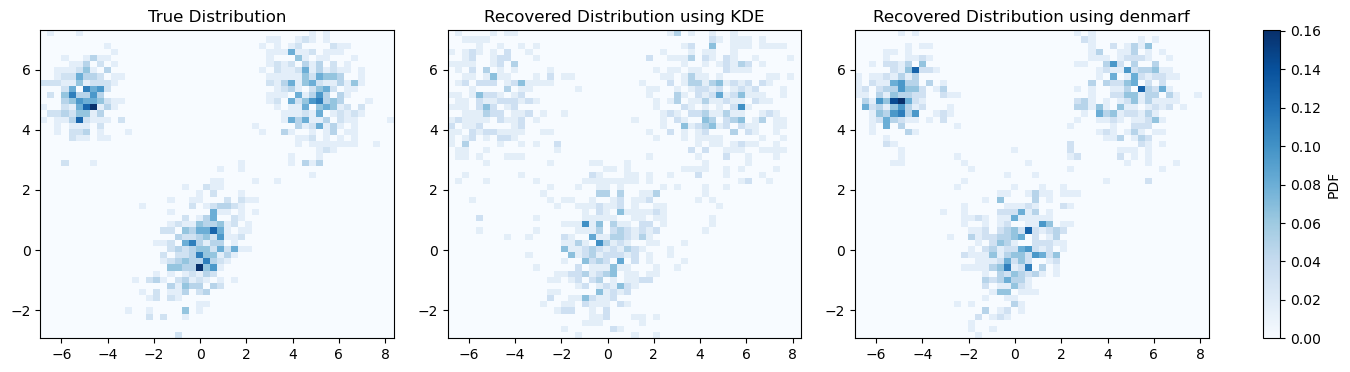

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), width_ratios=[20,20,20,1])

h1, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=50, density=True)
h2, _, _ = np.histogram2d(samples_kde[:,0], samples_kde[:,1], bins=[xedges, yedges], density=True)
h3, _, _ = np.histogram2d(samples_nfde[:,0], samples_nfde[:,1], bins=[xedges, yedges], density=True)
vmin = min(h1.min(), h2.min(), h3.min())
vmax = max(h1.max(), h2.max(), h3.max())

# True Distribution
im = axs[0].pcolormesh(xedges, yedges, h1.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[0].set_title("True Distribution")

# KDE
axs[1].pcolormesh(xedges, yedges, h2.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[1].set_title("Recovered Distribution using KDE")

# denmarf
axs[2].pcolormesh(xedges, yedges, h3.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[2].set_title("Recovered Distribution using denmarf")

fig.colorbar(im, cax=axs[3], label="PDF")

# plt.tight_layout()
plt.show()

In [23]:
comparison_df = pd.DataFrame({
    "True Distribution": log_density_true[:3],
    "KDE": log_density_kde[:3],
    "denmarf": log_density_nfde[:3]
})

display(comparison_df)

,True Distribution,KDE,denmarf
0,-4.151761,-4.379009,-4.980206
1,-2.867716,-3.535777,-3.028857
2,-2.826157,-3.509859,-3.017386


In [24]:
def get_KL_divergence(p_log_density, q_log_density):
    p = np.exp(p_log_density) / np.sum(np.exp(p_log_density))
    q = np.exp(q_log_density) / np.sum(np.exp(q_log_density))
    return np.sum(p * np.log(p / q))

In [25]:
print("KL Divergence between True Distribution and KDE:", get_KL_divergence(log_density_true, log_density_kde))
print("KL Divergence between True Distribution and NFDE:", get_KL_divergence(log_density_true, log_density_nfde))

KL Divergence between True Distribution and KDE: 0.05901321708445589
KL Divergence between True Distribution and NFDE: 0.03455517934572146


Removed no burn in
Removed no burn in


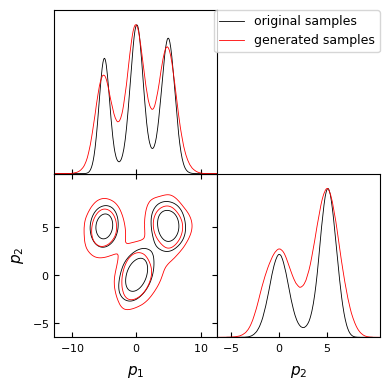

In [26]:
plot_corner(samples, kde) # Plot using KDE

Removed no burn in
Removed no burn in


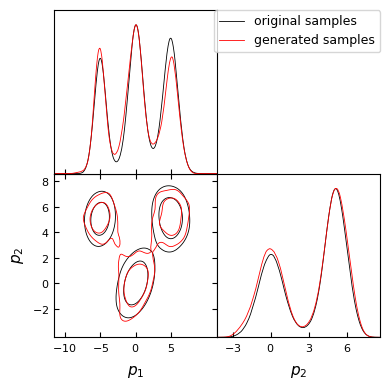

In [27]:
plot_corner(samples, nfde) # Plot using denmarf